In [2]:
import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import gdal
import geopandas as gpd
import descartes 
from shapely.geometry import Point, Polygon
#os.chdir('../../')
os.getcwd()

'C:\\Users\\leogo\\OneDrive\\Desktop\\PhD\\Analysis'

# Loading RHoMIS and Adding GeoPandas Geometry #

In [3]:
rhomis_indicator=pd.read_csv(
    os.path.join("data", "rhomis_data","RHoMIS_Indicators.csv"), 
    encoding="latin1", 
    low_memory=False)

latitude_not_null=rhomis_indicator.loc[:,"GPS_LAT"].notnull()
longitude_not_null=rhomis_indicator.loc[:,"GPS_LON"].notnull()
spatially_explicit_rhomis=rhomis_indicator.loc[latitude_not_null&longitude_not_null,:]

columns_to_subset=["GPS_LAT", 
                   "GPS_LON", 
                   "total_income_USD_PPP_pHH_Yr"]

spatially_explicit_rhomis=spatially_explicit_rhomis.loc[spatially_explicit_rhomis.loc[:,"ID_COUNTRY"]=="BF",:]
boolean_column_location=spatially_explicit_rhomis.columns.isin(columns_to_subset)
income_and_GPS=pd.DataFrame(spatially_explicit_rhomis.loc[:,boolean_column_location])

geometry=[Point(xy) for xy in zip(income_and_GPS["GPS_LON"], income_and_GPS["GPS_LAT"])]
crs={'init' :'epsg:4326'}
income_and_GPS = gpd.GeoDataFrame(income_and_GPS, geometry=geometry,crs=crs)

In [4]:
import re
shapefiles_in_folder=os.listdir(os.path.join("data", "shapefiles"))
regular_expression= re.compile(".*km")

#regex_shapefiles=[re.match(regular_expression, x) for x in shapefiles_in_folder]
#regex_shapefiles=[re.search(regular_expression, x) for x in shapefiles_in_folder]

regex_shapefiles=[]
for x in shapefiles_in_folder:
    temporary_matching=re.match(regular_expression, x)
    if temporary_matching is not None:
        regex_shapefiles.append(temporary_matching.group(0))
len(regex_shapefiles)

2

# Creating Spatial Grid over world shapefile #

In [5]:
world_shapefile=gpd.read_file(
    os.path.join('data', 'shapefiles', 'World'))


grid_size= 100000
#grid_size_km=grid_size/1000

def create_world_grid(world_shapefile, grid_size):
    radius_of_earth=6371000
    longitude_minimum, latitude_minimum, longitude_maximum, latitude_maximum=world_shapefile.total_bounds

    def append_polygons_list(polygons ,origin ,horizontal_step, vertical_step, horizontal_bound,vertical_bound):
        long_left=origin[0]
        lat_bottom=origin[1] 

        long_right=long_left+horizontal_step
        if abs(long_right)>abs(horizontal_bound):
            long_right=horizontal_bound

        lat_top=lat_bottom+vertical_step
        if abs(lat_top)>abs(vertical_bound):
            lat_top=vertical_bound

        polygons.append(Polygon([(long_left,lat_bottom),(long_left,lat_top),(long_right,lat_top),(long_right,lat_bottom)]))
        return polygons


    def update_origins(origin_south_west, origin_north_west, origin_north_east, origin_south_east, latitude_step, longitude_step):
        origin_south_west=[origin_south_west[0]-longitude_step,origin_south_west[1]-latitude_step]
        origin_north_west=[origin_north_west[0]-longitude_step,origin_north_west[1]+latitude_step]
        origin_north_east=[origin_north_east[0]+longitude_step,origin_north_east[1]+latitude_step]
        origin_south_east=[origin_south_east[0]+longitude_step,origin_south_east[1]-latitude_step]
        return origin_south_west, origin_north_west, origin_north_east, origin_south_east

    #initialising polygons list and setting coordinates to 0 lat 0 long
    polygons=[] 
    origin=[0,0] 
    origin_south_west=origin
    origin_north_west=origin
    origin_north_east=origin
    origin_south_east=origin


    latitude_limit=min([abs(latitude_minimum), abs(latitude_maximum)])
    longitude_limit=min([abs(longitude_minimum), abs(longitude_maximum)])

    # This is the increase in latitude required to produce grids of a particular size.
    latitude_step=(180*grid_size)/(math.pi*(radius_of_earth))
    sum_of_latitude_steps=0

    while sum_of_latitude_steps<latitude_limit:
        sum_of_longitude_steps=0    
        while sum_of_longitude_steps<180:
            # If we have a latitude of zero then our longitude step tends to infinity, must avoid this.
            if math.cos(math.radians(origin_north_west[1]))>0.01:
                # The change in longitude required to produce the particular grid size, this is important as it varies according to latitude
                longitude_step=(180*grid_size)/(math.pi*(radius_of_earth)*math.cos(math.radians(origin_north_west[1])))            
                sum_of_longitude_steps=sum_of_longitude_steps+longitude_step
                # north west movement
                polygons=append_polygons_list(polygons=polygons,
                                          origin=origin_north_west, 
                                          horizontal_step=-longitude_step,
                                          vertical_step=latitude_step,
                                          horizontal_bound=longitude_minimum,
                                         vertical_bound=latitude_maximum)
                # north east movement
                polygons=append_polygons_list(polygons=polygons,
                                          origin=origin_north_east, 
                                          horizontal_step=longitude_step,
                                          vertical_step=latitude_step,
                                          horizontal_bound=longitude_maximum,
                                         vertical_bound=latitude_maximum)

                # south west movement
                polygons=append_polygons_list(polygons=polygons,
                                          origin=origin_south_west, 
                                          horizontal_step=-longitude_step,
                                          vertical_step=-latitude_step,
                                          horizontal_bound=longitude_minimum,
                                         vertical_bound=latitude_minimum)

                # south east movement
                polygons=append_polygons_list(polygons=polygons,
                                          origin=origin_south_east, 
                                          horizontal_step=longitude_step,
                                          vertical_step=-latitude_step,
                                          horizontal_bound=longitude_maximum,
                                         vertical_bound=latitude_minimum)
                origin_south_west, origin_north_west, origin_north_east, origin_south_east=update_origins(origin_south_west, origin_north_west, origin_north_east, origin_south_east, latitude_step=0, longitude_step=longitude_step)

        origin_south_west, origin_north_west, origin_north_east, origin_south_east=update_origins(origin_south_west=[0,origin_south_west[1]], origin_north_west=[0,origin_north_west[1]], origin_north_east=[0,origin_north_east[1]], origin_south_east=[0,origin_south_east[1]], latitude_step=latitude_step, longitude_step=0)
        sum_of_latitude_steps=sum_of_latitude_steps+latitude_step



    grid = gpd.GeoDataFrame({'geometry':polygons})
    os.mkdir(os.path.join("data","shapefiles","world_grid_"+str(grid_size/1000)+"km"))
    grid.to_file(os.path.join("data","shapefiles","world_grid_"+str(grid_size/1000)+"km","grid.shp"))
    
#create_world_grid(world_shapefile, grid_size)

In [113]:
world_grid=gpd.read_file(os.path.join("data","shapefiles","world_grid_"+str(grid_size/1000)+"km","grid.shp"))
world_grid=gpd.GeoDataFrame(world_grid,crs={'init' :'epsg:4326'})


In [7]:
country="Burkina Faso"
boundary_for_country=world_shapefile.loc[world_shapefile.loc[:,'CNTRY_NAME']==country,:].boundary
total_bounds_for_country=world_shapefile.loc[world_shapefile.loc[:,'CNTRY_NAME']==country,:].total_bounds
country_geo_dataframe=world_shapefile.loc[world_shapefile.loc[:,'CNTRY_NAME']==country,:]
country_grid=gpd.overlay(country_geo_dataframe,world_grid,how="intersection")

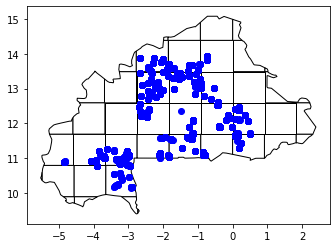

In [14]:
#country_rhomis_grid=gpd.sjoin(income_and_GPS,country_grid, op="within")
country_grid_boundary=country_grid.boundary
figure, ax= plt.subplots()
country_grid.plot(ax=ax, color="white", edgecolor="black")
income_and_GPS.plot(ax=ax, color="blue")

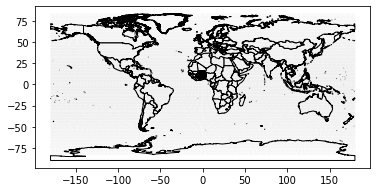

In [63]:
figure, ax= plt.subplots()
world_shapefile.plot(ax=ax, color="white", edgecolor="black")
world_grid.boundary.plot(ax=ax, color=None, edgecolor="black", linewidth=0.01)
income_and_GPS.plot(ax=ax, color="black", linewidth=0.01)

NameError: name 'y' is not defined

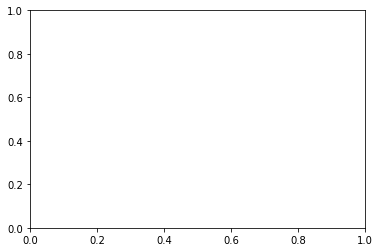

In [126]:
intersected_grid__points=gpd.sjoin(income_and_GPS,world_grid,'left').head()
intersected_grid__points_country=gpd.sjoin(income_and_GPS,world_shapefile,'left').head()
intersected_grid__points_country.head()


world_grid.loc[:,"FID"]


fig, ax = plt.subplots()
ax.scatter(x,y,marker=".")
ax.plot(x,y,marker="o")
#gpd.sjoin(income_and_GPS,world_grid,'inner')

plt.hist(income_and_GPS.loc[:,'total_income_USD_PPP_pHH_Yr'], color = 'blue', edgecolor = 'black',bins = int(180/5))
#income_and_GPS.geometry
#income_and_GPS.plot()